<a href="https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/ML_Collab_Article/example_output/ML_Collaboration_Dataset_Shift_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='red'>NOTE: This notebook is a stripped down version from our ArangoML Series. This notebook is intended for those following along with the ArangoML [Multi-model Collaboration post](https://www.arangodb.com/2021/01/arangoml-series-multi-model-collaboration/).</font>

The full post that introduces the covariate shift concept and details how to use the arangopipe dataset shift API can be found [here](https://www.arangodb.com/2020/11/arangoml-part-4-detecting-covariate-shift-in-datasets/).

# Dataset Shift
The following notebook is a simple example of how to detect shifts in your dataset using the arangopipe API. This example takes parts of the same dataset and compares them to each other, in a non-random fashion. The purpose of this is to show how the dataset shift API functions and the process of comparing parts of the same dataset is only for demonstration purposes. You would typically use a new or updated dataset to check the reliablity of the model against your new data.

In [1]:
%%capture
!pip install python-arango
!pip install arangopipe==0.0.6.9.3
!pip install pandas PyYAML==5.1.1 sklearn2
!pip install jsonpickle

In [2]:
import pandas as pd
import numpy as np
data_url = "https://raw.githubusercontent.com/arangoml/arangopipe/arangopipe_examples/examples/data/cal_housing.csv"
df = pd.read_csv(data_url, error_bad_lines=False)
df = df.sample(n = 500)
df.head()

,lat,long,housingMedAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
9848,-121.89,36.60,40,626,164,337,150,2.7917,225000.0
3524,-118.51,34.27,34,3787,771,1966,738,4.0550,222500.0
10071,-120.17,39.33,10,614,141,195,95,0.9283,116300.0
7262,-118.23,33.99,37,378,176,714,156,2.1912,112500.0
8795,-118.41,33.77,22,7554,991,2808,946,10.0600,500001.0


##  Exploring the Data

Let's take some time to explore the data a bit. First, we look at the types and shapes of the data to see what is available. 

In [3]:

req_cols = df.columns.tolist()
req_cols.remove("medianHouseValue")
df = df[req_cols]
df.dtypes

lat              float64
long             float64
housingMedAge      int64
totalRooms         int64
totalBedrooms      int64
population         int64
households         int64
medianIncome     float64
dtype: object

In [4]:
df["lat"].describe()

count    500.000000
mean    -119.521240
std        1.956794
min     -123.410000
25%     -121.662500
50%     -118.645000
75%     -117.970000
max     -115.500000
Name: lat, dtype: float64

When we plot the histogram of the lat variable, we see two populations (see below):
1. A group with lat values less than -119
2. A group with lat values greater than -119 

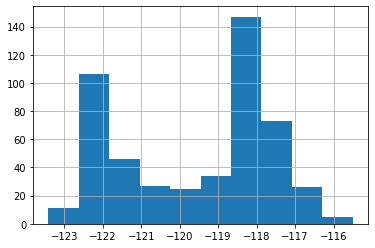

In [5]:

import matplotlib.pyplot as plt
%matplotlib inline  
df["lat"].hist()

Let’s pretend that the current batch of data used to develop our regression model is the first one, the group with lat values less than -119. By not selecting any houses with lat values greater than -119, we have introduced a sampling error. When selecting data for model development, you would want to use the entire range of lat values. Our second group consists of houses with lat values greater than -119.

In [6]:
df1 = df.query("lat <= -119")
df2 = df.query("lat > -119")

Can we discriminate between the two? 

Let’s develop a classifier and see if we can. 

## Using the dataset shift API
Here we use a [random forest classifier](https://en.wikipedia.org/wiki/Random_forest) and our Dataset Shift Detector to test our data and then print the returned score value. 

In [7]:
from arangopipe.arangopipe_analytics.rf_dataset_shift_detector import RF_DatasetShiftDetector

rfd = RF_DatasetShiftDetector()
score = rfd.detect_dataset_shift(df1, df2)
print ("Detaset shift score : %2.2f" % (score))

Detaset shift score : 0.99


## Interpretation of the score reported by the shift detector
The API uses a classifier to discriminate between the datasets provided to it. The score reported by the API is the accuracy of the classifier to discriminate between the datasets. Values close to  0.5  indicate that the classifier is not able to discriminate between the two datasets. This could be interpreted as a situation where no discernable shift has occurred in the data since the last model deployment. Values close to 1 indicate that the dataset shift is detectable, and we may need to revisit modeling. 

How the dataset shift affects the performance of the deployed model is problem-dependent. So we must assess the score in the context of a particular application. Usually, we perform experiments to determine a threshold value of the dataset shift score; the score represents an acceptable level of drift.

## Conclusion
This post introduced covariate shifts in datasets and provided an example of how easy it is to test this with ArangoML’s built-in API. The [Introduction to ArangoML series](https://www.arangodb.com/tag/arangoml/) will continue, so be sure to sign up for our newsletter to be notified of the next release!

You can also join us on the [ArangoML Slack channel](https://arangodb-community.slack.com/archives/CN9LVJ24S) if you have any questions or comments.

If you have something cool you are working on with ArangoML or ArangoDB in general we would love to learn about it. We now have an [interactive tutorials repository](https://github.com/arangodb/interactive_tutorials) where you can share your own notebook with the community, [check it out](https://github.com/arangodb/interactive_tutorials)!